In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from IPython.display import display

# print the JS visualization code to the notebook
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# data = pd.read_csv('banking.csv', header = 0)
# data.to_hdf('banking.h5', key='data', mode='w') 
data = pd.read_hdf('banking.h5', 'data')
print(data.shape)
print(list(data.columns))
display(data)

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


In [3]:
number_cols = list(data.select_dtypes(include='number').columns)
print("Number Columns:\n", number_cols)

object_cols = list(data.select_dtypes(include='object').columns)
print("Object Columns:\n", object_cols)

multi_cols = list(data.select_dtypes(include=['number', 'object']).columns)
print("Multi-Datatype Columns:\n", multi_cols)

exclude_cols = list(data.select_dtypes(exclude='number').columns)
print("Excluded Datatype Columns:\n", exclude_cols)

Number Columns:
 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
Object Columns:
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Multi-Datatype Columns:
 ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
Excluded Datatype Columns:
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [4]:
for col in object_cols:
    data[col] = data[col].astype("category")
    
display(data[object_cols])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,nonexistent
1,technician,married,unknown,no,no,no,cellular,nov,fri,nonexistent
2,management,single,university.degree,no,yes,no,cellular,jun,thu,success
3,services,married,high.school,no,no,no,cellular,apr,fri,nonexistent
4,retired,married,basic.4y,no,yes,no,cellular,aug,fri,success
...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,high.school,unknown,no,yes,telephone,jun,thu,nonexistent
41184,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,nonexistent
41185,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,nonexistent
41186,technician,married,professional.course,no,no,yes,telephone,oct,tue,nonexistent


In [5]:
X = data.copy()
y = data.copy()
X = X[multi_cols]
X = X.drop('y', axis=1)
y = y['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=12345,)
dtrain = xgb.DMatrix(data = X_train, label =  y_train, enable_categorical = True)
dtest = xgb.DMatrix(data = X_test, label =  y_test, enable_categorical = True)

In [6]:
# The model parameters are as follows:
# base_score - This is the prediction for initial models. It has a default score of 0.5.
# booster - This is the type of algorithm that is used to improve the model performance.
# colsample_bylevel - This shows how different branches levels are separated in the tree.
# colsample_bynode - It shows how different nodes are split.
# colsample_bytree - It shows how different trees in XGBoost are separated.
# gamma - This is used to reduce the loss when correcting model errors.
# learning_rate - The rate at which the XGBoost model learns during the training phase
# max_delta_step - This is used to update the model class during training.
# max_depth - This is the maximum depth of the XGBoost classifier.
# min_child_weight - This is the minimum size we are allowed to partition the tree’s leaf node.
# n_estimators - This is the total number of estimators added during model training.
# n_jobs - This is the total number of jobs handled by the model.
# objective - It specifies the type of algorithm used to build the model, in this case, it uses logistic regression.
# random_state - This seeding number is used by the model.
# reg_alpha - This is the parameter used to reduce the weights of the model.
# reg_lambda - This is the parameter used to increase the weights of the model.
# seed - The seed used by the model.
# subsample - The ratios we use to sample the training phases of a model.
# verbosity - It measures the verbosity of words in the dataset.

In [7]:
# It accepts integer specifying the number of rounds of the training process. 
# The algorithm will iterate over whole training data many times.
# Total number of built trees is num_parallel_tree * num_classes * num_boost_round
num_boost_round = 10

# create model instance
# supported tree methods are `gpu_hist`, `approx`, and `hist`.
param = {"booster": "gbtree"
         , "num_parallel_tree": 200
         , "max_depth": 6
         , "eval_metric": "auc"
         , "objective": "binary:hinge"
         , "tree_method": "approx"}

model = xgb.train(param,  num_boost_round = num_boost_round, dtrain = dtrain,
                 evals=[(dtrain, "train"), (dtest, "test")])

[0]	train-auc:0.50000	test-auc:0.50000
[1]	train-auc:0.87070	test-auc:0.87352
[2]	train-auc:0.86862	test-auc:0.86882
[3]	train-auc:0.85814	test-auc:0.85070
[4]	train-auc:0.84232	test-auc:0.83472
[5]	train-auc:0.83392	test-auc:0.82341
[6]	train-auc:0.82881	test-auc:0.81194
[7]	train-auc:0.82434	test-auc:0.80958
[8]	train-auc:0.81722	test-auc:0.79775
[9]	train-auc:0.81664	test-auc:0.79362


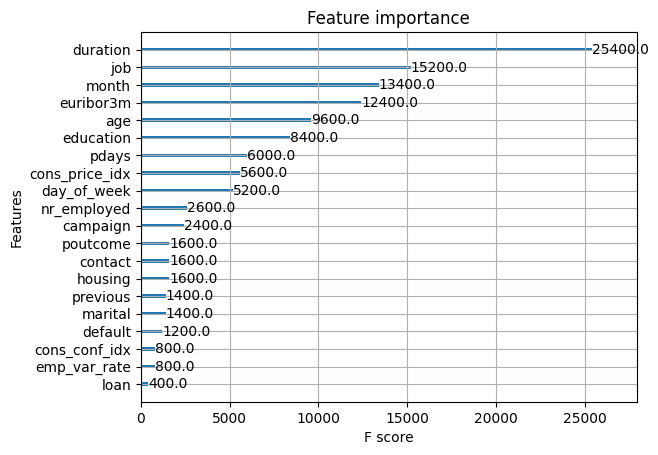

In [8]:
xgb.plot_importance(model)
plt.show()

In [9]:
model.get_fscore()

{'age': 9600.0,
 'job': 15200.0,
 'marital': 1400.0,
 'education': 8400.0,
 'default': 1200.0,
 'housing': 1600.0,
 'loan': 400.0,
 'contact': 1600.0,
 'month': 13400.0,
 'day_of_week': 5200.0,
 'duration': 25400.0,
 'campaign': 2400.0,
 'pdays': 6000.0,
 'previous': 1400.0,
 'poutcome': 1600.0,
 'emp_var_rate': 800.0,
 'cons_price_idx': 5600.0,
 'cons_conf_idx': 800.0,
 'euribor3m': 12400.0,
 'nr_employed': 2600.0}

In [10]:
# make predictions
y_pred = model.predict(dtest)

In [11]:
pd.crosstab(y_test, y_pred.astype(int), rownames=['Original'], colnames=['Predictions'])

Predictions,0,1
Original,,
0,10425,540
1,506,886


In [12]:
X = data.copy()
y = data.copy()
X = X[number_cols]
X = X.drop('y', axis=1)
y = y['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=12345,)
dtrain = xgb.DMatrix(data = X_train, label =  y_train)
dtest = xgb.DMatrix(data = X_test, label =  y_test)

In [13]:
def dmatrix_to_dataframe(dmatrix: xgb.DMatrix):
    columns = dmatrix.feature_names
    ndarray = dmatrix.get_data()
    shape = ndarray.get_shape()
    return pd.DataFrame(ndarray.data.reshape(shape), columns = columns)

In [14]:
# It accepts integer specifying the number of rounds of the training process. 
# The algorithm will iterate over whole training data many times.
# Total number of built trees is num_parallel_tree * num_classes * num_boost_round
num_boost_round = 10

# create model instance
# supported tree methods are `gpu_hist`, `approx`, and `hist`.
param = {"booster": "gbtree"
         , "num_parallel_tree": 100
         , "max_depth": 6
         , "eval_metric": "auc"
         , "objective": "binary:hinge"
         , "tree_method": "approx"}

model = xgb.train(param,  num_boost_round = num_boost_round, dtrain = dtrain,
                 evals=[(dtrain, "train"), (dtest, "test")])

[0]	train-auc:0.50000	test-auc:0.50000
[1]	train-auc:0.87108	test-auc:0.87482
[2]	train-auc:0.86670	test-auc:0.86722
[3]	train-auc:0.84991	test-auc:0.83984
[4]	train-auc:0.83613	test-auc:0.82289
[5]	train-auc:0.83301	test-auc:0.82039
[6]	train-auc:0.82727	test-auc:0.81538
[7]	train-auc:0.82144	test-auc:0.81051
[8]	train-auc:0.81433	test-auc:0.79855
[9]	train-auc:0.80995	test-auc:0.79381


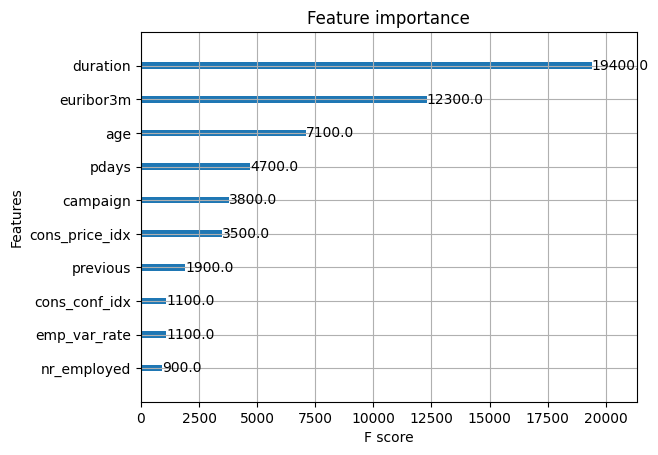

In [15]:
xgb.plot_importance(model)
plt.show()

In [16]:
model.get_fscore()

{'age': 7100.0,
 'duration': 19400.0,
 'campaign': 3800.0,
 'pdays': 4700.0,
 'previous': 1900.0,
 'emp_var_rate': 1100.0,
 'cons_price_idx': 3500.0,
 'cons_conf_idx': 1100.0,
 'euribor3m': 12300.0,
 'nr_employed': 900.0}

In [17]:
# Method returns histogram of splits for feature values. 
# Below we have created split values histogram for feature duration of data. 
# It gives us value and how many times a split has happened at that value.
split = model.get_split_value_histogram("duration")
split.sort_values('Count', ascending = False, inplace = True)
display(split)

,SplitValue,Count
9,181.193548,1200.0
0,82.919355,1000.0
8,170.274194,1000.0
25,421.419355,800.0
32,530.612903,800.0
...,...,...
37,628.887097,100.0
36,585.209677,100.0
35,574.290323,100.0
30,508.774194,100.0


In [18]:
split = model.get_split_value_histogram("duration")
split.sort_values('Count', ascending = False, inplace = True)
split_points = split['SplitValue'].to_list()
bins_tree = split_points[:3]
min_val = data["duration"].describe()['min']
max_val = data["duration"].describe()['max']
bins = bins_tree
bins.append(min_val)
bins.append(max_val)
bins = list(np.round(bins, 4))
bins = list(set(bins))
bins.sort()
print(bins)

[0.0, 82.9194, 170.2742, 181.1935, 4918.0]


<Axes: xlabel='duration', ylabel='Count'>

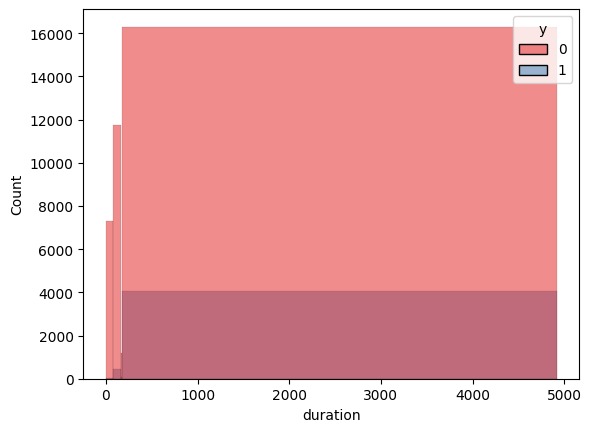

In [19]:
sns.histplot(x = "duration", hue = "y", bins = bins, data = data, palette = "Set1")

In [20]:
# Explain predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dmatrix_to_dataframe(dtrain))

In [21]:
# Visualize a single prediction (row or record)
X_display = dmatrix_to_dataframe(dtrain)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [22]:
# Visualize many predictions (Top 1.000 records)
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

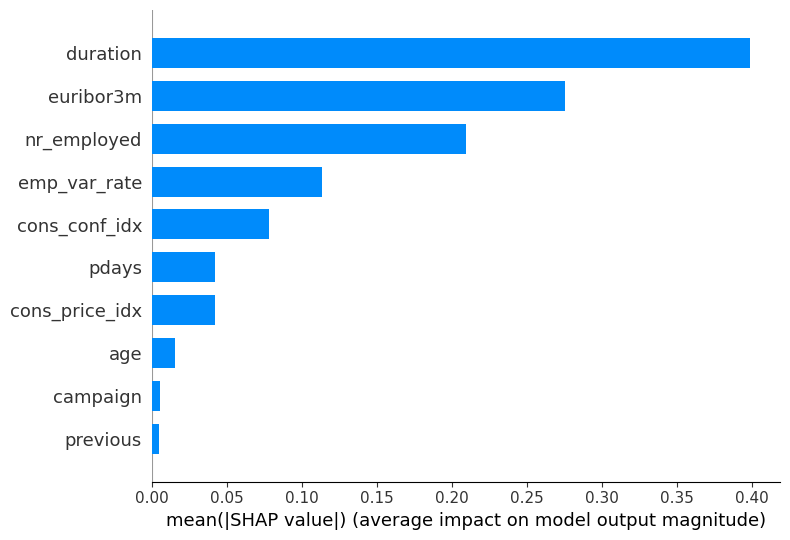

In [23]:
# Bar chart of mean importance
shap.summary_plot(shap_values, dmatrix_to_dataframe(dtrain), plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


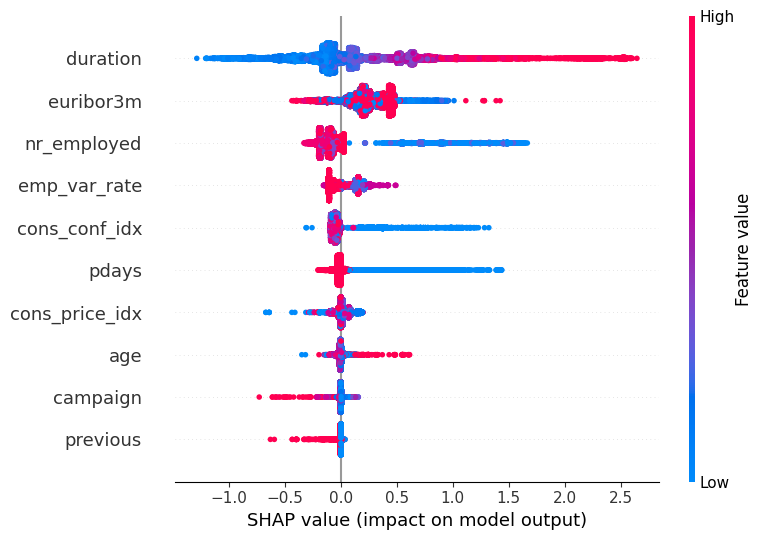

In [24]:
# SHAP Summary Plot
# Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values 
# for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. 
# Features are sorted by the sum of the SHAP value magnitudes across all samples.
shap.summary_plot(shap_values, dmatrix_to_dataframe(dtrain))

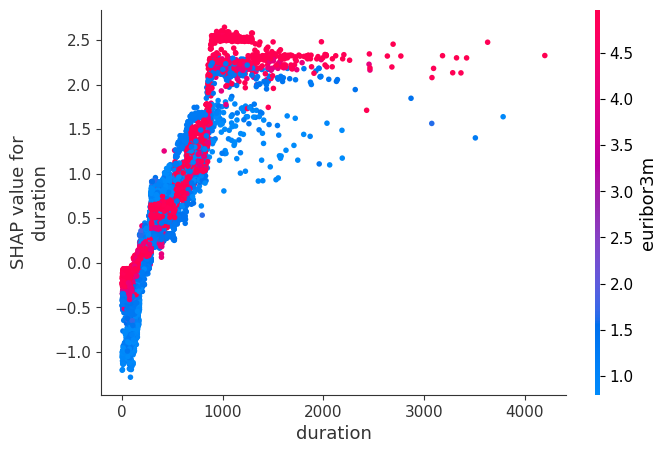

In [25]:
# SHAP Dependence Plots
# SHAP dependence plots show the effect of a single feature across the whole dataset. 
# They plot a feature’s value vs. the SHAP value of that feature across many samples. 
# SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects 
# present in the features, and are only defined in regions of the input space supported by data.
shap.dependence_plot("duration", shap_values, dmatrix_to_dataframe(dtrain))

In [26]:
# make predictions
y_pred = model.predict(dtest)

In [27]:
pd.crosstab(y_test, y_pred.astype(int), rownames=['Original'], colnames=['Predictions'])

Predictions,0,1
Original,,
0,10437,528
1,507,885
